In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

## Set up

In [3]:
import os
os.environ["PYTHONHASHSEED"] = "0"
os.environ["OMP_NUM_THREADS"] = "1"
import tqdm
import json
import joblib
import datetime
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
# from sklearn.base import BaseEstimator, clone
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error, mean_absolute_error, pairwise_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.stats import norm

import catboost as cb

from utils import load_config
from src.helpers import (
    ContiguousGroupKFold, 
    ContiguousTimeSeriesSplit,
    custom_log_likelihood, 
    # compute_per_station_metrics, 
    # get_station_stats, 
    # standardize_values, 
    # standardize_prediction_intervals, 
    # compute_per_station_metrics, 
    # summarize_metrics,
    # compute_non_negative_log_likelihood,
    # GroupMinMaxScaler,
    # GroupStandardScaler
)

from src.model import MultiOutputRegressor, create_gbt_model, GBTEnsembleRegressor

## Constants

In [4]:
config = load_config()

In [5]:
DATA_DIR = config['final_data']
TRAIN = os.path.join(DATA_DIR, 'train.csv')
TEST = os.path.join(DATA_DIR, 'eval.csv')
FEATURES = os.path.join(DATA_DIR, 'selected_features.csv')

## Modelling

- Direct Regressor: Predicts outputs and prediction interval directly
  - GBT with quantile loss
  - deep learning with quantile loss
- Ensemble Regressor: Uses a monte-carlo simulation to generate prediction interval
  - GBT with ensemble
  - deep learning with ensemble
- CV ensemble modelling - fold cross validation

In [6]:
CV_SPLIT = 5

#### Load data

In [7]:
df = pd.read_csv(TRAIN)
df_test = pd.read_csv(TEST)
df_features = pd.read_csv(FEATURES)

/tmp/ipykernel_1543545/181930374.py:1: DtypeWarning: Columns (35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(TRAIN)
/tmp/ipykernel_1543545/181930374.py:2: DtypeWarning: Columns (35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv(TEST)


In [8]:
CATEGORICAL = ['river', 'location', 'month', 'week', 'season', 'station_code']

In [9]:
for col in CATEGORICAL:
    df[col] = df[col].astype('str')
    df_test[col] = df_test[col].astype('str')

In [10]:
NUM_LOCATION = ['lat', 'lon', 'altitude']
NUM_SOIL = ['bdod', 'cfvo', 'clay', 'sand']
NUM_METEO = ['tp', 't2m', 'swvl1', 'evap']
COLS_TO_DROP = ['ObsDate', 'catchment', 'hydro_region', 'hydro_sector', 'hydro_sub_sector', 'hydro_zone', 'region_sector', 
    'region_sub_sector', 'region_zone', 'sector_sub_sector', 'sector_zone', 'sub_sector_zone']
TARGET_COLS = ['water_flow_week_1', 'water_flow_week_2', 'water_flow_week_3', 'water_flow_week_4']
LAG_COLS = ['water_flow_lag_1w', 'water_flow_lag_2w', 'water_flow_rolling_mean_4w']
CONTINUOUS_COLS = list(df.select_dtypes(['float', 'int']).drop(columns = TARGET_COLS + COLS_TO_DROP + LAG_COLS, errors = 'ignore').columns)

### Train Test Split
- Based on previous analysis, the dataset exhibits annual seasonality but no significant long-term trend.
- Therefore, it is acceptable to use chronological or block-wise splits without always reserving the most recent data for validation.
- This approach is appropriate for seasonally-repeating time series, where the assumption of trend-driven data drift does not hold.
- In such cases, the model's ability to generalize across seasonal cycles is more important than strict recency.

In [11]:
cgkf = ContiguousGroupKFold(5)
for idx, (train_ids, val_ids) in enumerate(cgkf.split(df, groups = df.year)):
    print(f'Years in fold {idx + 1}')
    print('Train:', *df.iloc[train_ids].year.unique())
    print('Validation:', *df.iloc[val_ids].year.unique())
    print('-------------------------------------------------------------------------')

Years in fold 1
Train: 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
Validation: 1990 1991 1992
-------------------------------------------------------------------------
Years in fold 2
Train: 1990 1991 1992 1996 1997 1998 1999 2000 2001 2002 2003 2004
Validation: 1993 1994 1995
-------------------------------------------------------------------------
Years in fold 3
Train: 1990 1991 1992 1993 1994 1995 1999 2000 2001 2002 2003 2004
Validation: 1996 1997 1998
-------------------------------------------------------------------------
Years in fold 4
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 2002 2003 2004
Validation: 1999 2000 2001
-------------------------------------------------------------------------
Years in fold 5
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
Validation: 2002 2003 2004
-------------------------------------------------------------------------


In [12]:
cgkf = ContiguousTimeSeriesSplit(5, 0.6)#, test_size = 2)
for idx, (train_ids, val_ids) in enumerate(cgkf.split(df, groups = df.year)):
    print(f'Years in fold {idx + 1}')
    print('Train:', *df.iloc[train_ids].year.unique())
    print('Validation:', *df.iloc[val_ids].year.unique())
    print('-------------------------------------------------------------------------')

Years in fold 1
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998
Validation: 1999 2000 2001 2002 2003 2004
-------------------------------------------------------------------------
Years in fold 2
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
Validation: 2000 2001 2002 2003 2004
-------------------------------------------------------------------------
Years in fold 3
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
Validation: 2001 2002 2003 2004
-------------------------------------------------------------------------
Years in fold 4
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
Validation: 2002 2003 2004
-------------------------------------------------------------------------
Years in fold 5
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
Validation: 2003 2004
-------------------------------------------------------------------------


### Load selected features and create transformers

In [17]:
selected_features_ = df_features.features.tolist()
X_train = df[selected_features_ + CATEGORICAL + ['year', 'latitude', 'longitude', 'river_ranking'] + COLS_TO_DROP]
y_train = df[TARGET_COLS]
X_train.shape, y_train.shape

In [22]:
gbt_transformer = ColumnTransformer(
    [
        ('scaler', MinMaxScaler(), list(X_train.drop(columns = CATEGORICAL + COLS_TO_DROP + TARGET_COLS + [i for i in X_train.columns if 'water_flow_lag' in i or 'water_flow_rolling' in i] + ['river_ranking'], errors = 'ignore').columns) ),   
        ('drop_cols', 'drop', COLS_TO_DROP)
    ],
    remainder = 'passthrough'
)

### Modelling

In [23]:
GBT_MODEL_PARAMS = {
    'iterations' : 1000,
    'depth': 10, 
    'l2_leaf_reg': 0.15520678413347222, 
    'min_data_in_leaf': 87, 
    'random_strength': 0.5878083922279745, 
    'bagging_temperature': 1.5885567609520757, 
    'border_count': 233,
    'grow_policy': 'Lossguide',
    'max_leaves': 39, 
    'one_hot_max_size': 2, #32,
    'od_type': 'Iter',
    'verbose':100,
    'bootstrap_type': 'Bayesian'
}

In [24]:
gbt_model = GBTEnsembleRegressor(
    model_fn = create_gbt_model,
    model_params = GBT_MODEL_PARAMS,
    preprocessor = gbt_transformer,
    cv = 5, 
    cv_group = 'year', 
    alphas = [0.05, 0.95], 
    method = 'indirect',
    n_models = 15,
    cat_features = CATEGORICAL, #['location', 'station_code'], #
    exclude_cols = COLS_TO_DROP,
    model_type = 'catboost',
    bootstrap = False,
    random_state = 42,
    delta = 0.01,
    patience = 100,
    min_patience = 20,
    lr = [0.05 for _ in range(15)], 
    split_type = 'time_series', 
    chained = True, 
    use_priors = True,
    enforce_location = False,
    location_column = 'location',
    k = 12,
)

In [25]:
%%time
gbt_model.fit(X_train, y_train)

/mnt/c/users/oluwa/OneDrive_V2/OneDrive/Competitions/codabench_water_scarcity/src/model.py:694: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()
/mnt/c/users/oluwa/OneDrive_V2/OneDrive/Competitions/codabench_water_scarcity/src/model.py:694: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


---------------------FOLD 0-------------------------
Training on years: 1990 1991 1992 1993 1994 1995 1996 1997 1998
Validating on years: 1999 2000 2001 2002 2003 2004
Training model fold_0_model_0
0:	learn: 74.8275910	test: 70.8160301	best: 70.8160301 (0)	total: 74.2ms	remaining: 1m 14s
100:	learn: 13.9758075	test: 16.9373741	best: 16.9373741 (100)	total: 1.6s	remaining: 14.2s
200:	learn: 12.5392649	test: 16.6075542	best: 16.5292203 (185)	total: 3.52s	remaining: 14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.52922033
bestIteration = 185

Shrink model to first 186 iterations.
0:	learn: 74.5625506	test: 70.5978791	best: 70.5978791 (0)	total: 21.4ms	remaining: 21.4s
100:	learn: 17.5705442	test: 21.2954161	best: 21.2888917 (95)	total: 2.41s	remaining: 21.5s
200:	learn: 15.9280616	test: 20.8341168	best: 20.8292727 (199)	total: 4.76s	remaining: 18.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 20.75183356
bestIteration = 238

Shrink model to f

/mnt/c/users/oluwa/OneDrive_V2/OneDrive/Competitions/codabench_water_scarcity/src/model.py:694: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_1_model_0
0:	learn: 74.0543233	test: 71.6405966	best: 71.6405966 (0)	total: 11.7ms	remaining: 11.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.78348641
bestIteration = 78

Shrink model to first 79 iterations.
0:	learn: 67.3957329	test: 64.5915984	best: 64.5915984 (0)	total: 13.4ms	remaining: 13.4s
100:	learn: 17.7880806	test: 21.3884897	best: 21.3588381 (83)	total: 2.05s	remaining: 18.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 21.35883806
bestIteration = 83

Shrink model to first 84 iterations.
0:	learn: 73.0498571	test: 69.9907171	best: 69.9907171 (0)	total: 16.1ms	remaining: 16.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25.60339501
bestIteration = 61

Shrink model to first 62 iterations.
0:	learn: 72.5783693	test: 69.4561335	best: 69.4561335 (0)	total: 38.9ms	remaining: 38.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 28.8727261
bestIteration = 73

Shrink model to 

/mnt/c/users/oluwa/OneDrive_V2/OneDrive/Competitions/codabench_water_scarcity/src/model.py:694: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_2_model_0
0:	learn: 74.0934628	test: 70.2980490	best: 70.2980490 (0)	total: 28ms	remaining: 27.9s
100:	learn: 13.6866917	test: 16.0897206	best: 16.0897206 (100)	total: 1m 58s	remaining: 17m 57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 15.94771655
bestIteration = 168

Shrink model to first 169 iterations.
0:	learn: 73.9161506	test: 69.4657719	best: 69.4657719 (0)	total: 55.8s	remaining: 15h 29m 16s
100:	learn: 17.8820290	test: 20.2208262	best: 20.2208262 (100)	total: 7m 22s	remaining: 1h 5m 37s
200:	learn: 16.2071944	test: 19.7956959	best: 19.7935105 (197)	total: 7m 31s	remaining: 29m 52s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 19.79250539
bestIteration = 201

Shrink model to first 202 iterations.
0:	learn: 73.3357240	test: 68.6475870	best: 68.6475870 (0)	total: 52.5s	remaining: 14h 33m 46s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 26.24362086
bestIteration = 43

Shrink model to first 44 itera

/mnt/c/users/oluwa/OneDrive_V2/OneDrive/Competitions/codabench_water_scarcity/src/model.py:694: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_3_model_0
0:	learn: 72.0691984	test: 76.1125906	best: 76.1125906 (0)	total: 17.4ms	remaining: 17.4s
100:	learn: 13.4588683	test: 16.4580376	best: 16.4580376 (100)	total: 2.71s	remaining: 24.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.17288119
bestIteration = 154

Shrink model to first 155 iterations.
0:	learn: 72.4001814	test: 74.4111868	best: 74.4111868 (0)	total: 15.2ms	remaining: 15.2s
100:	learn: 17.3503983	test: 20.4336786	best: 20.4204544 (99)	total: 2.6s	remaining: 23.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 20.05029213
bestIteration = 165

Shrink model to first 166 iterations.
0:	learn: 71.9618476	test: 73.5815554	best: 73.5815554 (0)	total: 14.9ms	remaining: 14.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 26.96450716
bestIteration = 44

Shrink model to first 45 iterations.
0:	learn: 72.6002286	test: 73.2233522	best: 73.2233522 (0)	total: 36.7ms	remaining: 36.7s
Stopped by overfi

/mnt/c/users/oluwa/OneDrive_V2/OneDrive/Competitions/codabench_water_scarcity/src/model.py:694: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tmp = tmp[['station_code', 'year', 'week', target_col]].pivot_table(index = 'week', columns = ['station_code', 'year'], values = target_col).groupby(level=0, axis=1).mean()


Training model fold_4_model_0
0:	learn: 73.4407450	test: 71.0269787	best: 71.0269787 (0)	total: 11.4ms	remaining: 11.4s
100:	learn: 13.8016730	test: 13.6945297	best: 13.6909507 (92)	total: 2.22s	remaining: 19.7s
200:	learn: 12.5469430	test: 12.9787250	best: 12.9787250 (200)	total: 4.35s	remaining: 17.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 12.97003453
bestIteration = 219

Shrink model to first 220 iterations.
0:	learn: 70.9664392	test: 66.7696364	best: 66.7696364 (0)	total: 23.3ms	remaining: 23.3s
100:	learn: 17.7610625	test: 18.9887116	best: 18.9453181 (84)	total: 2.89s	remaining: 25.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 18.42277823
bestIteration = 131

Shrink model to first 132 iterations.
0:	learn: 72.9548953	test: 65.2616440	best: 65.2616440 (0)	total: 17.2ms	remaining: 17.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 24.60876241
bestIteration = 37

Shrink model to first 38 iterations.
0:	learn: 74.3

##### Save and load model for inference

In [26]:
TIMESTAMP = datetime.datetime.now().strftime('%Y%m%dT%H%M')
METHOD = 'model_36'
VER = 1

In [27]:
save_path = f'./saved_models/{TIMESTAMP}_GBT_{METHOD}_{VER}'

In [28]:
gbt_model.save_model(save_path)

In [29]:
model = GBTEnsembleRegressor(use_priors = True, enforce_location = False)
model.load_model(save_path, create_gbt_model, GBT_MODEL_PARAMS)

In [30]:
feat_importances = model.get_feature_importances_()

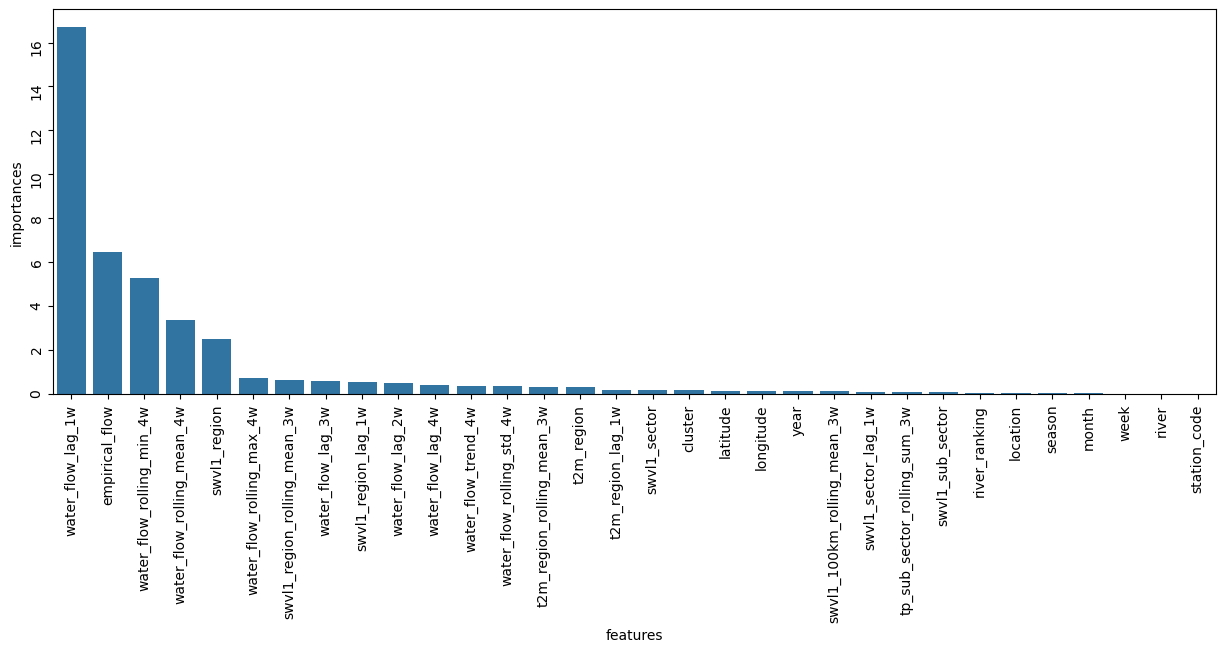

In [31]:
plt.figure(figsize = (15, 5))
sns.barplot(feat_importances.sort_values('importances', ascending = False).iloc[:50, :], x = 'features', y = 'importances')
plt.tick_params(rotation = 90)

In [32]:
np.mean(list(model.results.values()))

1.7105327759924118

In [35]:
X_test = df_test.drop(columns = 'dataset')
# X_test = X_test.drop(columns = X_train.columns)
X_test = X_test[X_train.columns]

In [46]:
%%time
res, _ = model.predict(X_test)

/mnt/c/users/oluwa/OneDrive_V2/OneDrive/Competitions/codabench_water_scarcity/src/model.py:767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbors = neighbors_df.iloc[indices[0]]
/mnt/c/users/oluwa/OneDrive_V2/OneDrive/Competitions/codabench_water_scarcity/src/model.py:767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbors = neighbors_df.iloc[indices[0]]
/mnt/c/users/oluwa/OneDrive_V2/OneDrive/Competitions/codabench_water_scarcity/src/model.py:767: SettingWithCopyWarning: 
A value is trying to be

CPU times: user 3.28 s, sys: 162 ms, total: 3.44 s
Wall time: 2.4 s


In [47]:
df_output = []
for key, value in res.items():
    temp = pd.DataFrame(value, columns = [f'week_{i}_{key}' for i in range(4)])
    df_output.append(temp)
df_output = pd.concat(df_output, axis = 1)
df_output = df_output.clip(0, np.inf)
df_output[df_output.filter(like = 'sup').columns] = df_output.filter(like = 'sup').astype('float') + 0.01
df_output[df_output.filter(like = 'inf').columns] = df_output.filter(like = 'inf').astype('float')# - 0.01
for i in range(0, 4):
    df_output[[f'week_{i}_inf', f'week_{i}_pred', f'week_{i}_sup']] = np.sort(df_output[[f'week_{i}_inf', f'week_{i}_pred', f'week_{i}_sup']].values, axis = 1)
df_output[['station_code', 'ObsDate']] = df_test[['station_code', 'ObsDate']]
key = ['pred', 'inf', 'sup']
df_output = df_output[['station_code'] + [f'week_{i}_{key[j]}' for i in range(4) for j in range(3)] + ['ObsDate']]

In [48]:
X_ = X_train.reset_index(drop = True)

6139921 TILLE


/tmp/ipykernel_1543545/73291905.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samp_X['ObsDate'] = pd.to_datetime(samp_X.ObsDate.values)
/tmp/ipykernel_1543545/73291905.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samp_X_true['ObsDate'] = pd.to_datetime(samp_X_true.ObsDate.values)


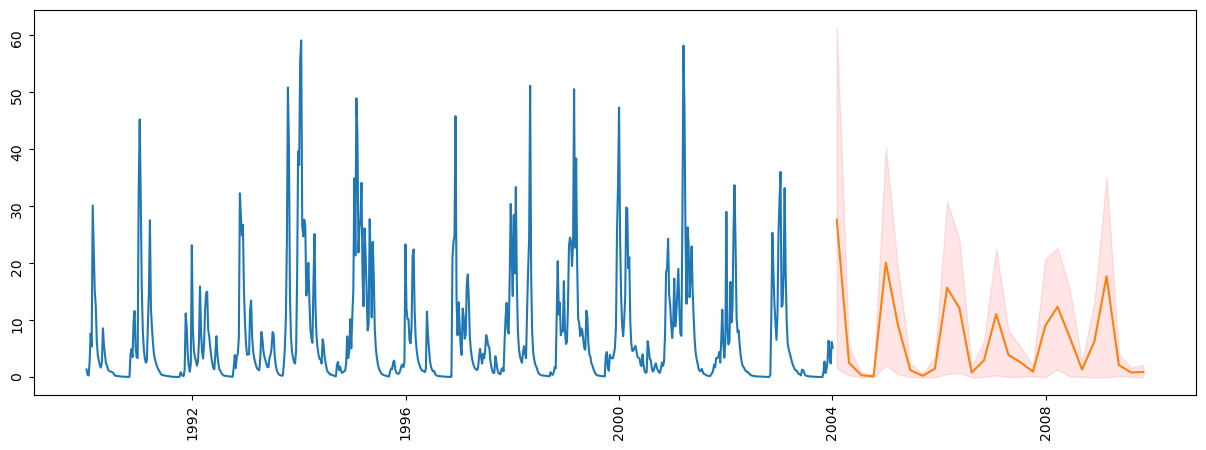

In [55]:
n = 0
j = 35 #12
station_codes = df_test.station_code.unique()
plt.figure(figsize = (15, 5))
samp_X = df_test[df_test.station_code == station_codes[j]] #'56610000'] #
samp_X_true = X_train[X_train.station_code == station_codes[j]]
samp_X['ObsDate'] = pd.to_datetime(samp_X.ObsDate.values)
samp_X_true['ObsDate'] = pd.to_datetime(samp_X_true.ObsDate.values)
samp_y_true = y_train.loc[samp_X_true.index]
pred_y = df_output.loc[samp_X.index]
plt.plot(samp_X_true.ObsDate, samp_y_true.iloc[:, n].values);
plt.plot(samp_X.ObsDate, pred_y.loc[:, f'week_{n+1}_pred'])
plt.fill_between(samp_X.ObsDate, pred_y.loc[:, f'week_{n+1}_inf'], pred_y.loc[:, f'week_{n+1}_sup'], color = 'red', alpha = 0.1)
plt.tick_params(rotation = 90)
print(station_codes[j], samp_X.river.unique()[0])

In [81]:
df_output.to_csv('predictions.csv', index = False)